In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [5]:
def plot_predictions(test, predicted):
    plt.plot(test, color = 'red', label = "Real IBM Stock Price")
    plt.plot(predicted, color = 'blue', label = 'Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()
    
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print('Teh root mean squared error is {}'.format(rmse))

In [7]:
dataset = pd.read_csv("../input/stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv", index_col = 'Date', parse_dates = ['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [8]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

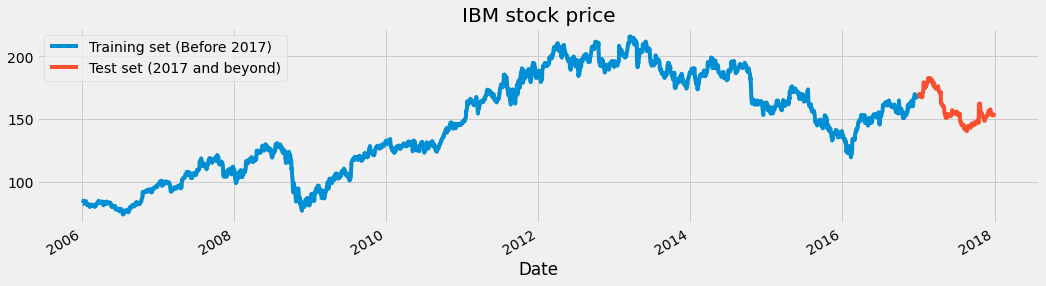

In [11]:
# We have chosen 'high' attribute for prices. Let's see what it looks like
dataset['High'][:'2016'].plot(figsize = (16,4), legend=True)
dataset['High']['2017':].plot(figsize = (16,4), legend=True)
plt.legend(['Training set (Before 2017)', 'Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [12]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
#trainig_set_scaled length is 2769

In [13]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
x_train = []
y_train = []
for i in range(60, 2769):
    x_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [21]:
regressor = Sequential()
# First LSTM Layer with dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM Layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM Layer
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM Layer
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# The output Layer
regressor.add(Dense(units = 1))
# Compling the RNN
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
# Fitting to the training set
regressor.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
85/85 [==============================] - 12s 15ms/step - loss: 0.0578
Epoch 2/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0114
Epoch 3/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0097
Epoch 4/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0077
Epoch 5/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0061
Epoch 6/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0053
Epoch 7/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0058
Epoch 8/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0045
Epoch 9/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0041
Epoch 10/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 11/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 12/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0040
Epoch 13/50
85/85 [=================

In [23]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [24]:
x_test = []
for i in range(60, 311):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

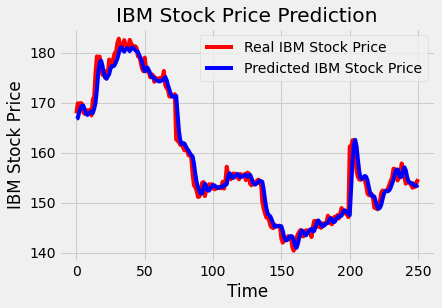

In [25]:
plot_predictions(test_set, predicted_stock_price)

In [26]:
return_rmse(test_set, predicted_stock_price)

Teh root mean squared error is 1.90923596455684
